In [13]:
# Core
import sys
import pandas as pd
import numpy as np
from pathlib import Path

## Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
import seaborn as sns

## Harp/Bonsai
sys.path.append('../../src/')
from bonsai import load_bonsai_config
load_bonsai_config(r"C:\git\AllenNeuralDynamics\aind-vr-foraging\Bonsai")
import harp
import harp.processing
import data_io

#Global Viz settings
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

default_img_size = (15, 8)

## From GitHub

[aind-vr-foraging Issue #81](https://github.com/AllenNeuralDynamics/aind-vr-foraging/issues/81)


### Notes:

- Sessions from 10/10/2023
    - 102
      - 7, 18.10, 28.47, 31.57
    - 103
      - 9.23, 10.06, 12.33, 15.08, 29.36 (manually given water), 38.11, 49.23
    - 107
      - 9.17, 10.29, 11.18, 13.40, 15.19


1. Check for Reward Sites
2. Check for ChoiceFeedback
3. Check for Licks
4. Check for GiveReward
5. Check the valve events (both time and onset)


In [2]:
session_path = Path(r"Z:\scratch\vr-foraging\672102\20231010T094441")


# Harp Devices:
HarpBehavior = harp.HarpDevice("Behavior")
harp_behavior_data = data_io.HarpSource(device=HarpBehavior, path=session_path / "Behavior", name="behavior", autoload=False)

# Software Events
software_events = data_io.SoftwareEventSource(path=session_path / "SoftwareEvents", name="software_events")

C:\Users\bruno.cruz\AppData\Local\Temp\ipykernel_35060\1958812007.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valve_output_pulse['pulse_duration'] = -1


[-1 50]


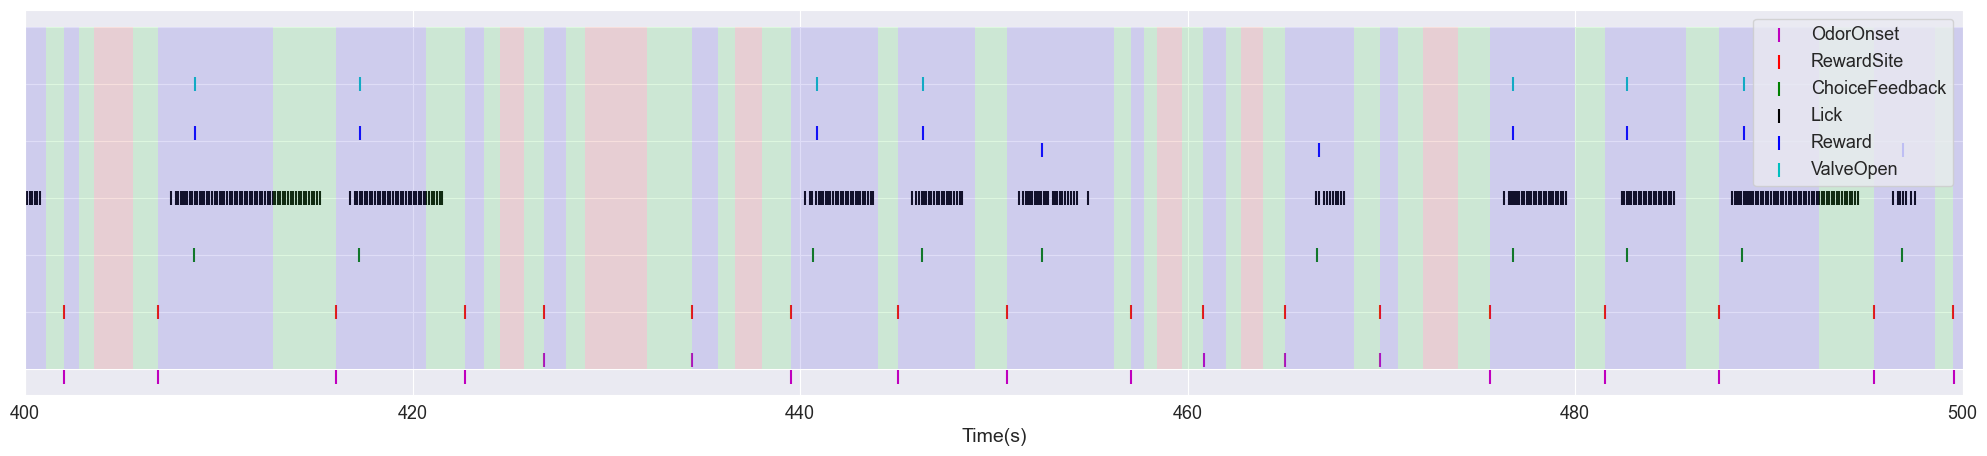

In [74]:
# Find reward sites
sites = software_events.streams.ActiveSite.data
reward_sites = sites.loc[sites["data"].apply(lambda x : x['label'] == 'Reward'), :]

# Find ChoiceFeedback events (i.e. successful stops)
choice_feedback = software_events.streams.ChoiceFeedback.data

# Check for licks

## mask for digital inputs
digital_inputs = HarpBehavior.module.DigitalInputs

harp_behavior_data.streams.DigitalInputState.load_from_file()
di_state = harp_behavior_data.streams.DigitalInputState.data
di_port0 = di_state["Value"].apply(lambda x : x.HasFlag(digital_inputs.DIPort0))
di_port0 = di_port0.loc[di_port0.diff() == True]
lick_onset = di_port0.loc[di_port0 == True]

# Find give reward event
give_reward = software_events.streams.GiveReward.data

zero_index = reward_sites.index[0]

# Find hardware reward events

harp_behavior_data.streams.PulseSupplyPort0.load_from_file() # Duration of each pulse
pulse_duration = harp_behavior_data.streams.PulseSupplyPort0.data
digital_outputs = HarpBehavior.module.DigitalOutputs
harp_behavior_data.streams.OutputSet.load_from_file()
valve_output_pulse = harp_behavior_data.streams.OutputSet.data
valve_output_pulse = valve_output_pulse.loc[valve_output_pulse["Value"].apply(lambda x: x.HasFlag(digital_outputs.SupplyPort0))]


valve_output_pulse['pulse_duration'] = -1
for seconds, contents in valve_output_pulse.iterrows():
    idx, _ = harp.processing.find_closest(seconds, pulse_duration.index.values, mode='below_zero')
    if not np.isnan(idx):
        valve_output_pulse.loc[seconds, 'pulse_duration'] = pulse_duration.iloc[idx].Value

print(valve_output_pulse["pulse_duration"].unique())


harp_behavior_data.streams.OutputSet.load_from_file()
harp_behavior_data.streams.OutputClear.load_from_file()
odor_0 = harp.processing.distinct_until_changed_state(harp_behavior_data.streams.OutputSet.data, harp_behavior_data.streams.OutputClear.data, digital_outputs.SupplyPort1)
odor_1 = harp.processing.distinct_until_changed_state(harp_behavior_data.streams.OutputSet.data, harp_behavior_data.streams.OutputClear.data, digital_outputs.SupplyPort2)

odors_onset = pd.concat(
    [
        odor_0[odor_0["Value"]].assign(Value=0),
        odor_1[odor_1["Value"]].assign(Value=1),
    ], axis=0, copy=True).sort_index()



# Start plotting raster
plt.figure(figsize=(25,5))
plt.scatter(odors_onset.index - zero_index, odors_onset["Value"] * 0.3 - 0.15, marker="|", s=100, c="m", label="OdorOnset")
plt.scatter(reward_sites.index - zero_index, reward_sites.index * 0 + 1, marker="|", s=100, c="r", label="RewardSite")
plt.scatter(choice_feedback.index - zero_index, choice_feedback.index * 0 + 2, marker="|", s=100, c="g", label="ChoiceFeedback")
plt.scatter(lick_onset.index - zero_index, lick_onset.index * 0 + 3, marker="|", s=100, c="k", label="Lick")
plt.scatter(give_reward.index - zero_index, (give_reward["data"] *0.3 ) - 0.15 + 4, marker="|", s=100, c="b", label="Reward")
plt.scatter(valve_output_pulse.index - zero_index, valve_output_pulse.index*0 + 5 , marker="|", s=100, c="c", label="ValveOpen")

label_cm = sns.color_palette('hls', len(sites["data"].apply(lambda x : x["label"]).unique()))
label_dict = {label : color for label, color in zip(sites["data"].apply(lambda x : x["label"]).unique(), label_cm)}

for idx, site in enumerate(sites.iloc[:-1].iterrows()):
    p = Rectangle(
        (sites.index[idx] - zero_index, 0), sites.index[idx+1] - sites.index[idx], 6,
        linewidth = 0, facecolor = label_dict[site[1]["data"]["label"]], alpha = 0.2 )
    plt.gca().add_patch(p)


plt.gca().set_yticklabels([])
plt.xlabel("Time(s)")
plt.legend()
plt.xlim((400, 500))
plt.show()


{'id': 11.0,
 'label': 'InterPatch',
 'length': 55.747537163994025,
 'odor': None,
 'render': {'brightness': 1.0},
 'reward': None,
 'startPosition': 11.965049743652344}